# Fig. 3


Execution time: 3 min (ngamma=20) to 17 min (ngamma=100) 

Note: ilocal converges for ngamma=20

## Setup 

Setup "_fisher_info_limits2_" virtual environment

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
from matplotlib import pyplot as plt;
import scipy.io as sio
import numpy as np
from numpy import log
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# import custom package
from src import nodes

# setup ilocal parmaeters
SEED = 10
ngamma = 20     # default=100;
gamma0 = 0.01
gamma_max = 200
eta = 1e-4
ny = 101         # discretisation of y = x + sqrt(gamma)*noise. Adapt depending on gamma and tuning curve discretization.
amp = 20         # max possible spike count

# setup cell data path
CELL_DATA_PATH = 'data/contrast_cells/carlo_data_cellno3.mat'       # cell responses and image principal components
METRICS_DATA_PATH = 'data/computed_contrast_cells/BDEvSSI_no3.npz'  # precomputed information metrics

# setup figure paraleters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 495 µs, sys: 0 ns, total: 495 µs
Wall time: 422 µs


## Load dataset

In [ ]:
%%time

# load the data for a single cell
mat = sio.loadmat(CELL_DATA_PATH)
np.random.seed(SEED)

# get the displayed images principal components and evoked neural responses
pcs = mat['X_lowd'] # principal components of natural images
fit = mat['f']      # average firing rate evoked by the images 

CPU times: user 815 ms, sys: 96.9 ms, total: 912 ms
Wall time: 911 ms


## Prior


In [ ]:
# set parameters
mu0 = pcs[0].mean()
mu1 = pcs[1].mean()
sigma = np.cov(pcs[0], pcs[1])

## Tuning curve

In [ ]:
%%time

# setup 2-D Gaussian prior p(images) parameters
# - zero mean and data-driven covariance

baseline = 1e-2

# get neuron's 2-D tuning curve
# - train a neural net to predict RGCs responses in natural image 2-D latent space (space of (PC1,PC2) values)
_, tuning_curve_model, _, grid_x, grid_y, latent_space_scaled, latent_space = nodes.nnet_fit(pcs[:2], fit, linspace=np.linspace(-10,10,100))

# - predict neural responses in the image 2-D latent space (2-D tuning curve)
rate_preds = nodes.tuning_curve_nnet(latent_space, tuning_curve_model)
tuning_curve = rate_preds.reshape(grid_x.shape) + baseline

Epoch 1/200, Train Loss: 0.3598, Val Loss: 0.4067
Epoch 20/200, Train Loss: 0.0421, Val Loss: 0.0617
Epoch 40/200, Train Loss: 0.0211, Val Loss: 0.0413
Epoch 60/200, Train Loss: 0.0171, Val Loss: 0.0354
Epoch 80/200, Train Loss: 0.0162, Val Loss: 0.0350
Epoch 100/200, Train Loss: 0.0157, Val Loss: 0.0343
Epoch 120/200, Train Loss: 0.0153, Val Loss: 0.0341
Epoch 140/200, Train Loss: 0.0149, Val Loss: 0.0338
Epoch 160/200, Train Loss: 0.0146, Val Loss: 0.0337
Epoch 180/200, Train Loss: 0.0143, Val Loss: 0.0335
Epoch 200/200, Train Loss: 0.0140, Val Loss: 0.0334
CPU times: user 5.27 s, sys: 3.81 ms, total: 5.27 s
Wall time: 226 ms


## 2D latent space

In [99]:
# x points to plot, from -xmax to xmax
nx = grid_x.shape[0]
xmax = latent_space.max()              # 10 - OK! = 10 for grid linspace on -10 to 10 with 100 steps
x = np.linspace(-xmax, xmax, nx)[None] # of shape (1,100)
dx = x[0,1] - x[0,0]                   # note: dx is 10 X smaller than in replication - OK! = 0.202

# create neuron 2D tuning curve f(PC1,PC2) 
firingrate = rate_preds.reshape(nx,nx)

## Compute SSI

Execution time: 0.3 secs

In [ ]:
# compute/load neural information metrics 
# ssi, ssi_bound, mse, rmse = compute_ssi_and_bayes_mse_via_method1(pcs, grid_x, grid_y, tuning_c, sigma, latent_space, load=True, metrics_data_path=METRICS_DATA_PATH)
ssi, Inf_ssi, logpx, logpr_x, logpr = nodes.compute_ssi(latent_space, firingrate, dx, amp=20, Sigmax=sigma)

# unit-test
# test_ssi(SSI, Inf_ssi, logpx, logpr_x, logpr) # works only for default parameters of the functions

## Compute $I_{local}$

Execution time: 17 min

In [101]:
Ilocal, Inf, gamma = nodes.compute_ilocal(latent_space, tuning_curve_model, nx, dx, ny, ngamma, gamma0, gamma_max, eta, amp, sigma)

Computing ilocal: 100%|██████████| 20/20 [03:27<00:00, 10.38s/it]


## Plot

6.300963416901047
CPU times: user 2.09 s, sys: 7.14 ms, total: 2.1 s
Wall time: 989 ms


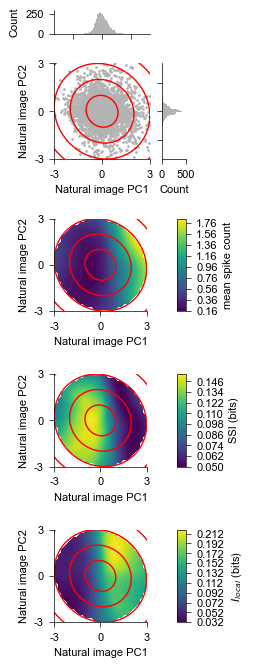

In [102]:
%%time

# setup parameters
xylim = (-3,3)
xyticks = (-3,0,3)

# Create mask for 3 standard deviations
mask_3std = nodes.create_gaussian_mask(grid_x, grid_y, np.array([mu0, mu1]), sigma, n_std=3)

# Apply mask to data
preds_masked = np.where(mask_3std, rate_preds.reshape(grid_x.shape), np.nan)
ssi_masked = np.where(mask_3std, ssi, np.nan)
Ilocal_masked = np.where(mask_3std, Ilocal, np.nan)

# setup plot
fig = plt.figure(figsize=(1.7,8))

# create main GridSpec: 1 col, 3 rows
gs_main = gridspec.GridSpec(4,1, figure=fig, wspace=0, height_ratios=[1.5,1,1,1])

# First subplot: Stimulus pcs & histogram --------------------------------------------------------------------------------
gs_top = gridspec.GridSpecFromSubplotSpec(2, 2,
                                          subplot_spec=gs_main[0],
                                          width_ratios=[4, 1],
                                          height_ratios=[1, 4],
                                          hspace=0.5, wspace=0.2)

# create axes for the mosaic
axs = {}
axs['histx'] = fig.add_subplot(gs_top[0, 0])
axs['scatter'] = fig.add_subplot(gs_top[1, 0])
axs['histy'] = fig.add_subplot(gs_top[1, 1])

# plot scatter points and histograms
nodes.scatter_hist(pcs[0], pcs[1], axs['scatter'], axs['histx'], axs['histy'], c=(.7,0.7,0.7))
axs['scatter'].set_aspect('equal')
axs['scatter'].set_xlabel('Natural image PC1')
axs['scatter'].set_ylabel('Natural image PC2')
axs['scatter'].set_xlim(xylim)
axs['scatter'].set_ylim(xylim)
axs['scatter'].set_xticks(xyticks,xyticks)
axs['scatter'].set_yticks(xyticks,xyticks)

# plot prior (contours)
for n_std in np.arange(0, 5, 1):
    nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         axs['scatter'], n_std=n_std,
                         edgecolor='red', facecolor='None')

# aesthetics
axs['scatter'].spines[['top','right']].set_visible(False)
axs['histx'].spines[['top','right']].set_visible(False)
axs['histx'].set_ylabel('Count')
axs['histy'].spines[['top','right']].set_visible(False)
axs['histy'].set_xlabel('Count')

# Second subplot: Tuning curve and prior --------------------------------------------------------------------------------

ax_bottom = fig.add_subplot(gs_main[1])

# plot tuning curve as heatmap (MASKED - white outside 3 std)
im = ax_bottom.contourf(grid_x, grid_y, preds_masked, levels=50, cmap='viridis', extend='neither')
ax_bottom.set_facecolor('white')  # Set background to white for masked regions
# colorbar
divider = make_axes_locatable(ax_bottom)
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label="mean spike count")

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         ax_bottom, n_std=n_std,
                         edgecolor='red', facecolor='None')

# formatting
ax_bottom.set_aspect('equal')
ax_bottom.spines[['right']].set_visible(False)
ax_bottom.set_xlabel("Natural image PC1")
ax_bottom.set_ylabel("Natural image PC2")
ax_bottom.set_xlim(xylim)
ax_bottom.set_ylim(xylim)
ax_bottom.set_xticks(xyticks,xyticks)
ax_bottom.set_yticks(xyticks,xyticks)
ax_bottom.spines[['top','right']].set_visible(False)

# Third subplot: plot SSI (MASKED - white outside 3 std) ----------------------------------------------------
ax_bottom3 = fig.add_subplot(gs_main[2])
im = ax_bottom3.contourf(grid_x, grid_y, ssi_masked/log(2), levels=50, cmap='viridis', extend='neither')

# formatting
ax_bottom3.set_facecolor('white')  # Set background to white for masked regions
ax_bottom3.set_xlim(xylim)
ax_bottom3.set_ylim(xylim)
ax_bottom3.set_xticks(xyticks,xyticks)
ax_bottom3.set_yticks(xyticks,xyticks)
# colorbar
divider = make_axes_locatable(ax_bottom3)
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label='SSI (bits)')

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         ax_bottom3, n_std=n_std,
                         edgecolor='red', facecolor='None')
# formatting
ax_bottom3.set_xlabel("Natural image PC1")
ax_bottom3.set_ylabel("Natural image PC2")
ax_bottom3.set_aspect('equal')
ax_bottom3.spines[['top','right']].set_visible(False)



# Fourth subplot: plot Ilocal (MASKED - white outside 3 std) ----------------------------------------------------
ax_bottom3 = fig.add_subplot(gs_main[3])
im = ax_bottom3.contourf(grid_x, grid_y, Ilocal_masked / log(2), levels=50, cmap='viridis', extend='neither')

# formatting
ax_bottom3.set_facecolor('white')  # Set background to white for masked regions
ax_bottom3.set_xlim(xylim)
ax_bottom3.set_ylim(xylim)
ax_bottom3.set_xticks(xyticks,xyticks)
ax_bottom3.set_yticks(xyticks,xyticks)
# colorbar
divider = make_axes_locatable(ax_bottom3)
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label='$I_{local}$ (bits)')

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    nodes.plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         ax_bottom3, n_std=n_std,
                         edgecolor='red', facecolor='None')
# formatting
ax_bottom3.set_xlabel("Natural image PC1")
ax_bottom3.set_ylabel("Natural image PC2")
ax_bottom3.set_aspect('equal')
ax_bottom3.spines[['top','right']].set_visible(False)

# format figure
fig.subplots_adjust(wspace=0.9, hspace=0.5)

# save figure
plt.savefig(f'figures/fig3_ngamma_{ngamma}.svg', bbox_inches = 'tight', transparent=True, dpi=400)
plt.savefig(f'figures/fig3_ngamma_{ngamma}.pdf', bbox_inches = 'tight', transparent=True, dpi=400)

## Control I_local

# Fig. 3

**Author**: laquitainesteeve@gmail using codes from Carlo Paris and Matthew Chalk

**Description**: Compute the ssi and ilocal metrics for a toy model of RGCs 2D-tuning curves firing_rate(PC1, PC2), where PC1 and PC2 are the first two principal components of a natural images.

**Execution time**: 20 min (ngamma=100); convergence within 3 min with ngamma=20

CPU times: user 139 ms, sys: 899 µs, total: 140 ms
Wall time: 139 ms


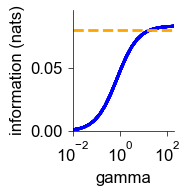

In [103]:
%%time 

igamma = len(gamma)

# plot convergence
plt.figure(2, figsize=(2,2))

# plt.semilogx(gamma[:igamma], Inf[:igamma], 'b-', linewidth=2, label='plug in')
plt.semilogx(gamma[:igamma], Inf[:igamma], 'b-', linewidth=2, label='plug in')

plt.axhline(Inf_ssi, color='orange', linestyle='--', linewidth=2, 
            label=r'$\int_0^\gamma \langle I_{\gamma}(x)\rangle_{p(x)} d\gamma$')

plt.xlabel('gamma', fontsize=12)
plt.ylabel('information (nats)', fontsize=12)
plt.ylim([0, 1.2 * Inf_ssi])
plt.xlim([gamma[0], gamma[igamma-1]])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tick_params(labelsize=12)
plt.tight_layout()
# 
plt.savefig(f'figures/fig3_info_converg_ngamma_{ngamma}.svg', bbox_inches = 'tight', transparent=True, dpi=400)
plt.savefig(f'figures/fig3_info_converg_ngamma_{ngamma}.pdf', bbox_inches = 'tight', transparent=True, dpi=400)